### Download the different data sources

In [8]:
from pathlib import Path
import urllib

download_path = "./download_files"

def download_if_not_exist(filename : str, download_url : str, download_dir : Path = Path(download_path)):
    download_dir.mkdir(exist_ok=True)
    output_file = download_dir / filename
    if not output_file.exists():
        urllib.request.urlretrieve(download_url,output_file)

download_if_not_exist("variants.csv",           "https://opendata.ecdc.europa.eu/covid19/virusvariant/csv/data.csv")
download_if_not_exist("measures.csv",           "https://www.ecdc.europa.eu/sites/default/files/documents/response_graphs_data_2022-05-05.csv")
download_if_not_exist("cases_and_deaths.csv",   "https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv")
download_if_not_exist("vaccinations.csv",       "https://opendata.ecdc.europa.eu/covid19/vaccine_tracker/csv/data.csv")
download_if_not_exist("tests.csv",              "https://opendata.ecdc.europa.eu/covid19/testing/csv/data.csv")
download_if_not_exist("hospital_occupation.csv","https://opendata.ecdc.europa.eu/covid19/hospitalicuadmissionrates/csv/data.csv")
download_if_not_exist("cases_per_age_group.csv","https://opendata.ecdc.europa.eu/covid19/agecasesnational/csv/data.csv")


#population_data https://databank.worldbank.org/Population/id/5fffa8a4 ## Tooo complicated to load this data through the api... this is complete bullshit...

### Transform the sources into a usable format

In [9]:
import pandas as pd
import numpy as np
processed_path = Path("./processed_data")
#Create Cases and Deaths Data Frames
data_files = Path("./data_files")
data_files.mkdir(exist_ok=True)
data_files.mkdir(exist_ok=True)


In [10]:
countries_of_interest = ["Austria", "Belgium", "Denmark", "France", "Italy", "Netherlands", "Poland", "Spain", "Sweden"]

#### Extract data out of `cases_and_deaths.csv`

In [11]:
### this should be skipped
%%script false --no-raise-error

#load the original dataframe
cases_and_deaths_df = pd.read_csv(f"{download_path}/cases_and_deaths.csv",sep=",",parse_dates=["dateRep"],dayfirst=True)[["dateRep","countriesAndTerritories","cases","deaths","popData2020"]]

#extract the population data
population_df = cases_and_deaths_df[["countriesAndTerritories","popData2020"]].groupby("countriesAndTerritories").mean()

def calc_incidence(country_series:pd.Series,population_df:pd.DataFrame) -> pd.Series:
    '''Calculates the Incidence as defined by the RKI'''
    country_pop = population_df.loc[country_series.name].values[0]
    incidence_7d_series = country_series.copy()
    incidence_7d_series.name = "incidence7days"
    for d in range(len(country_series)):
        sum_last_seven_cases = country_series[max(0,d-7):d].sum()
        incidence_7d_series[d] = (sum_last_seven_cases/country_pop)*100000
    return incidence_7d_series

#create the cases dataframe
if not Path(data_files,"cases.csv").exists():
    cases_df = cases_and_deaths_df[["dateRep","countriesAndTerritories","cases"]].pivot(index="dateRep",columns="countriesAndTerritories")["cases"].reset_index()
    cases_df.set_index("dateRep", inplace=True)
    cases_df.columns.name = None
    cases_df.index.name = None
    cases_df.to_csv(Path(data_files,"cases.csv"),sep=",")
    
    if not Path(data_files,"cases_incidences.csv").exists():
        #create a case incidence df
        case_incidence_7_days_df = cases_df.apply(lambda x: calc_incidence(x,population_df=population_df),axis=0)
        case_incidence_7_days_df.to_csv(Path(data_files,"cases_incidences.csv"),sep=",")

#create the deaths dataframe
if not Path(data_files,"deaths.csv").exists():
    deaths_df = cases_and_deaths_df[["dateRep","countriesAndTerritories","deaths"]].pivot(index="dateRep",columns="countriesAndTerritories")["deaths"].reset_index()
    deaths_df.set_index("dateRep",inplace=True)
    deaths_df.columns.name = None
    deaths_df.index.name = None
    deaths_df.to_csv(Path(data_files,"deaths.csv"))

    if not Path(data_files,"deaths_incidences.csv").exists():
        #create a deaths incidence df
        death_incidence_7_days_df = deaths_df.apply(lambda x: calc_incidence(x,population_df=population_df),axis=0)
        death_incidence_7_days_df.to_csv(Path(data_files,"deaths_incidences.csv"),sep=",")

UsageError: Line magic function `%%script` not found.


### Load Population Data from the World Bank

In [12]:
def add_age_group_totals(country_age_groups_df:pd.DataFrame)->pd.DataFrame:
    country_age_groups_df["<15yr"] = ((
        country_age_groups_df["00-04 male"].values[0]+
        country_age_groups_df["05-09 male"].values[0]+
        country_age_groups_df["10-14 male"].values[0]
        )/100*country_age_groups_df["Population male"].values[0])+((
        country_age_groups_df["00-04 female"].values[0]+
        country_age_groups_df["05-09 female"].values[0]+
        country_age_groups_df["10-14 female"].values[0]
        )/100*country_age_groups_df["Population female"].values[0])
    country_age_groups_df["15-24yr"] = ((
        country_age_groups_df["15-19 male"].values[0]+
        country_age_groups_df["20-24 male"].values[0]
        )/100*country_age_groups_df["Population male"].values[0])+((
        country_age_groups_df["15-19 female"].values[0]+
        country_age_groups_df["20-24 female"].values[0]
        )/100*country_age_groups_df["Population female"].values[0])
    country_age_groups_df["25-49yr"] = ((
        country_age_groups_df["25-29 male"].values[0]+
        country_age_groups_df["30-34 male"].values[0]+
        country_age_groups_df["35-39 male"].values[0]+
        country_age_groups_df["40-44 male"].values[0]+
        country_age_groups_df["45-49 male"].values[0]
        )/100*country_age_groups_df["Population male"].values[0])+((
        country_age_groups_df["25-29 female"].values[0]+
        country_age_groups_df["30-34 female"].values[0]+
        country_age_groups_df["35-39 female"].values[0]+
        country_age_groups_df["40-44 female"].values[0]+
        country_age_groups_df["45-49 female"].values[0]
        )/100*country_age_groups_df["Population female"].values[0])
    country_age_groups_df["50-64yr"] = ((
        country_age_groups_df["50-54 male"].values[0]+
        country_age_groups_df["55-59 male"].values[0]+
        country_age_groups_df["60-64 male"].values[0]
        )/100*country_age_groups_df["Population male"].values[0])+((
        country_age_groups_df["50-54 female"].values[0]+
        country_age_groups_df["55-59 female"].values[0]+
        country_age_groups_df["60-64 female"].values[0]
        )/100*country_age_groups_df["Population female"].values[0])
    country_age_groups_df["65-79yr"] = ((
        country_age_groups_df["65-69 male"].values[0]+
        country_age_groups_df["70-74 male"].values[0]+
        country_age_groups_df["75-79 male"].values[0]
        )/100*country_age_groups_df["Population male"].values[0])+((
        country_age_groups_df["65-69 female"].values[0]+
        country_age_groups_df["70-74 female"].values[0]+
        country_age_groups_df["75-79 female"].values[0]
        )/100*country_age_groups_df["Population female"].values[0])
    country_age_groups_df["80+yr"] = ((
        country_age_groups_df["80+ male"].values[0]
        )/100*country_age_groups_df["Population male"].values[0])+((
        country_age_groups_df["80+ female"].values[0]
        )/100*country_age_groups_df["Population female"].values[0])
    return country_age_groups_df[["Population total","<15yr","15-24yr","25-49yr","50-64yr","65-79yr","80+yr"]]


population_age_groups_df = pd.read_csv(f"{download_path}/population_data.csv")
population_age_groups_df["i"] = 1

def shorten_name(s:str)->str:
    s = str(s)
    if len(s)<=10:
        return s
    age = s.split(",")[0].split(" ")[-1]
    age = "80+" if "above" in age else age
    gender = s.split(",")[-1].split(" ")[1]
    return f"{age} {gender}"


country_age_groups_df = pd.DataFrame()
population_age_groups_df["Series Name"] = population_age_groups_df["Series Name"].apply(shorten_name)

population_age_groups_df.set_index("i",inplace=True)
population_age_groups_df.index.name = None
population_age_groups_df.replace("..",np.nan,inplace=True)

population_df = pd.DataFrame()
for name, group in population_age_groups_df.groupby("Country Name"):
    group_df = group[["Series Name","2020 [YR2020]"]].pivot(columns='Series Name')['2020 [YR2020]'].astype(float)
    temp_df = add_age_group_totals(group_df)
    pd.options.mode.chained_assignment = None  # default='warn
    temp_df["country"] = name
    pd.options.mode.chained_assignment = "warn"  # default='warn
    temp_df.set_index("country",inplace=True)
    population_df = pd.concat([population_df,temp_df])
population_df.to_csv(f"{data_files}/population_df.csv")
population_df.rename(index={"Czech Republic": "Czechia"},inplace=True)
population_df

Series Name,Population total,<15yr,15-24yr,25-49yr,50-64yr,65-79yr,80+yr
country,,,,,,,
Albania,2837849.0,4.891271e+05,4.220120e+05,9.448140e+05,5.646016e+05,3.337525e+05,8.354190e+04
Andorra,77265.0,NaN,NaN,NaN,NaN,NaN,NaN
Armenia,2963234.0,6.173120e+05,3.469740e+05,1.089468e+06,5.597340e+05,2.580640e+05,9.168200e+04
Austria,8916864.0,1.285116e+06,9.515760e+05,2.998192e+06,1.969586e+06,1.229053e+06,4.833417e+05
Azerbaijan,10093121.0,2.373429e+06,1.350203e+06,3.919469e+06,1.769588e+06,5.479836e+05,1.324487e+05
Belarus,9379952.0,1.617137e+06,8.627188e+05,3.442619e+06,1.996063e+06,1.095676e+06,3.657382e+05
Belgium,11544241.0,1.966443e+06,1.293400e+06,3.736134e+06,2.325508e+06,1.567222e+06,6.555344e+05
Bosnia and Herzegovina,3280815.0,4.764520e+05,3.812030e+05,1.093227e+06,7.421490e+05,4.643260e+05,1.234580e+05
Bulgaria,6934015.0,1.017877e+06,6.134584e+05,2.405021e+06,1.409070e+06,1.163241e+06,3.253479e+05


In [13]:
#population_df.loc["Spain"]["Population total"]
#test = 
#test

#### Extract data out of `cases_and_deaths.csv` and `hospital_occupation.csv`

In [14]:
#load cases and deaths
cnd = pd.read_csv(f"{download_path}/cases_and_deaths.csv")
cnd["dateRep"] = pd.to_datetime(cnd["dateRep"],format="%d/%m/%Y")
cnd.rename(columns={"dateRep":"date","countriesAndTerritories":"country"},inplace=True)

#load hospital occupation
honi = pd.read_csv(f"{download_path}/hospital_occupation.csv",sep=",")
honi["date"] = pd.to_datetime(honi["date"])
left = honi[honi["indicator"]=="Daily hospital occupancy"]
right = honi[honi["indicator"]=="Daily ICU occupancy"]
new_honi = pd.merge(left[["country","date","year_week","value"]],right[["country","date","year_week","value"]],how="outer",on=["country","date","year_week"])
new_honi.rename(columns={"value_x":"hospital_occupation","value_y":"icu_occupation"},inplace=True)

#combine daily data to one df
combined_df = pd.merge(cnd,new_honi,on=["country","date"],how="outer")
combined_df = combined_df[["date","country","cases","deaths","hospital_occupation","icu_occupation"]].fillna(value=0.0)

#calc incidence
def calc_incidence_grouped(country_series:pd.Series,country:str,population_df:pd.DataFrame,group:str = "All") -> pd.Series:
    '''Calculates the Incidence as defined by the RKI'''
    group = "Population total" if group == "All" else group
    country_pop = population_df.loc[country][group]
    incidence_7d_series = country_series.copy()
    for d in range(len(country_series)):
        if "occupation" in country_series.name:
            last_seven_cases = country_series[max(0,d-7):d].median()
        else:
            last_seven_cases = country_series[max(0,d-7):d].sum()
        incidence_7d_series[d] = (last_seven_cases/country_pop)*100000
    return incidence_7d_series

#calc the incidence for every country
grouped = combined_df.groupby(["country"])
daily_df = pd.DataFrame()
for name, group in grouped:
    if name not in countries_of_interest:
        continue
    group.set_index("date",inplace=True)
    group.sort_index(inplace=True)
    group["cases_incidence"] = calc_incidence_grouped(group["cases"],country=name,population_df=population_df)
    group["deaths_incidence"] = calc_incidence_grouped(group["deaths"],country=name,population_df=population_df)
    group["hospital_incidence"] = calc_incidence_grouped(group["hospital_occupation"],country=name,population_df=population_df)
    group["icu_incidence"] = calc_incidence_grouped(group["icu_occupation"],country=name,population_df=population_df)
    temp_df = group.reset_index()
    daily_df = pd.concat([daily_df,temp_df])

daily_df.replace(0, np.nan, inplace=True)
#save combined data to csv
daily_df.to_csv(f"{data_files}/daily_data_and_incidence_df.csv")

<AxesSubplot:xlabel='date'>

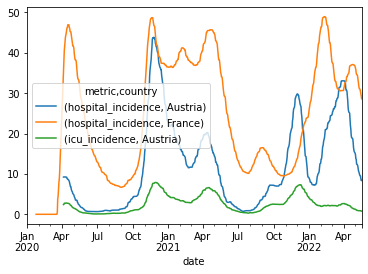

In [15]:
pdaily_df = daily_df.pivot(index="date",columns="country")
pdaily_df.columns.names = ["metric","country"]
pdaily_df.fillna(method="ffill",inplace=True)
pdaily_df[[("hospital_incidence","Austria"),("hospital_incidence","France"),("icu_incidence","Austria")]].plot()#.columns#.plot(figsize=(28,12))

In [16]:
pdaily_df

metric       cases                                                       \
country    Austria Belgium Denmark   France    Italy Netherlands Poland   
date                                                                      
2020-01-01     NaN     NaN     NaN      NaN      NaN         NaN    NaN   
2020-01-02     NaN     NaN     NaN      NaN      NaN         NaN    NaN   
2020-01-03     NaN     NaN     NaN      NaN      NaN         NaN    NaN   
2020-01-04     NaN     NaN     NaN      NaN      NaN         NaN    NaN   
2020-01-05     NaN     NaN     NaN      NaN      NaN         NaN    NaN   
...            ...     ...     ...      ...      ...         ...    ...   
2022-05-13  3750.0  3182.0   765.0  32773.0  39029.0      1280.0  429.0   
2022-05-14  3392.0  1402.0   427.0  30459.0  36334.0      1158.0  390.0   
2022-05-15  2545.0   482.0   488.0  22844.0  27726.0      1008.0  129.0   
2022-05-16  3200.0    12.0   570.0   5936.0  13776.0       825.0   91.0   
2022-05-17  3200.0    12.0   803.0  43727.0  44901.0      1249.0  461.0   

metric                      deaths  ... hospital_incidence icu_incidence  \
country       Spain Sweden Austria  ...             Sweden       Austria   
date                                ...                                    
2020-01-01      1.0    NaN     NaN  ...                NaN           NaN   
2020-01-02      1.0    NaN     NaN  ...                NaN           NaN   
2020-01-03      1.0    NaN     NaN  ...                NaN           NaN   
2020-01-04      1.0    NaN     NaN  ...                NaN           NaN   
2020-01-05      1.0    NaN     NaN  ...                NaN           NaN   
...             ...    ...     ...  ...                ...           ...   
2022-05-13  68234.0  368.0     2.0  ...          11.068783      0.885962   
2022-05-14  68234.0  368.0     2.0  ...          11.068783      0.885962   
2022-05-15  68234.0  368.0     2.0  ...          11.068783      0.885962   
2022-05-16  68234.0  368.0     5.0  ...          11.068783      0.785029   
2022-05-17  52112.0  368.0     5.0  ...          11.068783      0.785029   

metric                                                                      \
country      Belgium   Denmark    France Italy Netherlands Poland    Spain   
date                                                                         
2020-01-01       NaN       NaN       NaN   NaN         NaN    NaN      NaN   
2020-01-02       NaN       NaN       NaN   NaN         NaN    NaN      NaN   
2020-01-03       NaN       NaN       NaN   NaN         NaN    NaN      NaN   
2020-01-04       NaN       NaN       NaN   NaN         NaN    NaN      NaN   
2020-01-05       NaN       NaN       NaN   NaN         NaN    NaN      NaN   
...              ...       ...       ...   ...         ...    ...      ...   
2022-05-13  1.013492  0.171485  2.048088   NaN    0.240805    NaN  1.43993   
2022-05-14  1.013492  0.171485  2.024342   NaN    0.240805    NaN  1.43993   
2022-05-15  0.961518  0.188634  1.972398   NaN    0.240805    NaN  1.43993   
2022-05-16  0.909544  0.205782  1.917486   NaN    0.240805    NaN  1.43993   
2022-05-17  0.909544  0.205782  1.829922   NaN    0.240805    NaN  1.43993   

metric                
country       Sweden  
date                  
2020-01-01       NaN  
2020-01-02       NaN  
2020-01-03       NaN  
2020-01-04       NaN  
2020-01-05       NaN  
...              ...  
2022-05-13  0.222148  
2022-05-14  0.270441  
2022-05-15  0.270441  
2022-05-16  0.270441  
2022-05-17  0.270441  

[868 rows x 72 columns]

In [17]:
#Daily
#Cases, Deaths, icu, hosp

# Weekly
#Tests, Variants, Cases, Deaths, Hospital, ICU, total_second_vaccs, total_booster_vaccs

#Weekly/Age Group
#Cases/Age Group,Vaccinations/Age group

#Measures

#### Extract data out of `cases_per_age_group.csv` and `vaccinations_per_age_group.csv`

In [18]:
country_codes = pd.read_csv("download_files/member_states.csv",sep=",",index_col="Code").to_dict()["Country"]
import numpy as np
age_groups = {
        "Age0_4"    :"<15yr",
        "Age5_9"    :"<15yr",
        "Age10_14"  :"<15yr",
        "Age15_17"  :"15-24yr",
        "Age18_24"  :"15-24yr",
        "Age25_49"  :"25-49yr",
        "Age50_59"  :"50-64yr",
        "Age60_69"  :"65-79yr",
        "Age70_79"  :"65-79yr",
        "Age80+"    :"80+yr",
        "ALL"       :"ALL",
        "Age<18": np.nan,
        "AgeUNK": np.nan,
        "HCW" : np.nan,
        "LTCF":np.nan,
        "1_Age60+":np.nan,
        "1_Age<60":np.nan
        }
#load vaccs per age group
vaccinations_per_age_group = pd.read_csv(f"{download_path}/vaccinations.csv")
vaccinations_per_age_group["date"] = pd.to_datetime(vaccinations_per_age_group["YearWeekISO"].apply(lambda d:d+"-1"), format='%Y-W%W-%w')
vaccinations_per_age_group["age_group"] = vaccinations_per_age_group["TargetGroup"].apply(lambda x : age_groups[x])
vaccinations_per_age_group["country"] = vaccinations_per_age_group["ReportingCountry"].apply(lambda x : country_codes[x[0:2]])
#vaccinations_per_age_group.set_index("date",inplace=True)

cases_per_age_group = pd.read_csv(f"{download_path}/cases_per_age_group.csv")
cases_per_age_group["date"] = pd.to_datetime(cases_per_age_group["year_week"].apply(lambda d:d+"-1"), format='%Y-%W-%w')

#combine the data
relevant_vaccs_per_age_group = vaccinations_per_age_group[["date","country","age_group","FirstDose","SecondDose","DoseAdditional1"]].groupby(["date","country","age_group"]).sum()
weekly_age_group_df = pd.merge(cases_per_age_group,relevant_vaccs_per_age_group,how="outer",left_on=["date","country","age_group"],right_on=["date","country","age_group"])
weekly_age_group_df = weekly_age_group_df[["date","country","age_group","FirstDose","SecondDose","DoseAdditional1","new_cases"]].groupby(["date","country","age_group"]).sum().reset_index()
weekly_age_group_df.to_csv(f"{data_files}/weekly_age_group_df.csv")

In [19]:
weekly_age_group_df

,date,country,age_group,FirstDose,SecondDose,DoseAdditional1,new_cases
0,2020-01-06,Austria,15-24yr,0.0,0.0,0.0,0.0
1,2020-01-06,Austria,25-49yr,0.0,0.0,0.0,0.0
2,2020-01-06,Austria,50-64yr,0.0,0.0,0.0,0.0
3,2020-01-06,Austria,65-79yr,0.0,0.0,0.0,0.0
4,2020-01-06,Austria,80+yr,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
25527,2022-05-16,Slovakia,25-49yr,4.0,3.0,37.0,0.0
25528,2022-05-16,Slovakia,50-64yr,0.0,3.0,7.0,0.0
25529,2022-05-16,Slovakia,65-79yr,0.0,0.0,11.0,0.0
25530,2022-05-16,Slovakia,<15yr,3.0,1.0,0.0,0.0


### Load population Data from the Word Bank 

In [20]:
vaccinations_per_age_group[vaccinations_per_age_group["Country"]=="France"]

KeyError: 'Country'

In [ ]:


for i in vaccinations_per_age_group["Country"].value_counts().index:
    country_df = vaccinations_per_age_group[vaccinations_per_age_group["Country"]==i]
    country_df = country_df[pd.notna(country_df["Group"])]
    country_df = country_df.groupby(["Date","Group"]).sum()[["FirstDose","SecondDose","DoseAdditional1"]]
    country_df
    break
    #country_df.to_csv(f"{processed_path}/{i}_weekly.csv")
country_df

FirstDose  SecondDose  DoseAdditional1
Date       Group                                          
2020-12-28 15-24yr          0           0                0
           25-49yr         51           0                0
           50-64yr         27           0                0
           65-79yr          3           0                0
           80+yr            6           0                0
...                       ...         ...              ...
2022-05-16 50-64yr          0           6              141
           65-79yr          7          12              201
           80+yr            0           3               45
           <15yr           18          36               21
           ALL            102         165             1346

[511 rows x 3 columns]

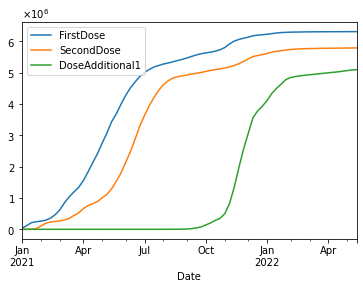

In [ ]:
vaccinations_per_age_group[["Country","FirstDose","SecondDose","DoseAdditional1","Group"]].groupby(["Group","Country"]).sum()
austria = vaccinations_per_age_group[vaccinations_per_age_group["Country"]=="Austria"]
austria = austria[austria["Group"]=="ALL"].groupby(["Date","Group"]).sum()[["FirstDose","SecondDose","DoseAdditional1"]]
austria.groupby("Date").sum().cumsum()[["FirstDose","SecondDose","DoseAdditional1"]].plot().ticklabel_format(axis="y",scilimits=(0,0),useMathText=True)

In [ ]:
relevant_vaccs_per_age_group = vaccinations_per_age_group[["Country","FirstDose","SecondDose","DoseAdditional1","Group","YearWeekISO"]].groupby(["Date","Country","Group","YearWeekISO"]).sum().reset_index()
weekly_age_group_df = pd.merge(cases_per_age_group,relevant_vaccs_per_age_group,how="outer",left_on=["Date","country","age_group"],right_on=["Date","Country","Group"])
weekly_age_group_df = weekly_age_group_df[["Date","Country","Group","FirstDose","SecondDose","DoseAdditional1","new_cases","rate_14_day_per_100k","YearWeekISO"]]

In [ ]:
combined_df[(combined_df["Country"]=="Austria") & (combined_df["Date"] == "2021-09-06")]

,Date,Country,Group,FirstDose,SecondDose,DoseAdditional1,new_cases,rate_14_day_per_100k,YearWeekISO
90,2021-09-06,Austria,<15yr,4333.0,3259.0,4.0,2830.0,379.000037,2021-W36
216,2021-09-06,Austria,15-24yr,12164.0,7983.0,81.0,2841.0,548.630441,2021-W36
342,2021-09-06,Austria,25-49yr,23665.0,13143.0,934.0,5528.0,340.335786,2021-W36
468,2021-09-06,Austria,50-64yr,6812.0,3777.0,795.0,1937.0,172.960740,2021-W36
594,2021-09-06,Austria,65-79yr,5556.0,3568.0,1661.0,610.0,90.348893,2021-W36
720,2021-09-06,Austria,80+yr,1173.0,784.0,1750.0,314.0,114.517880,2021-W36
24273,2021-09-06,Austria,ALL,44793.0,25706.0,5215.0,NaN,NaN,2021-W36


In [ ]:
relevant_vaccs_per_age_group

,Date,Country,Group,YearWeekISO,FirstDose,SecondDose,DoseAdditional1
0,2020-12-14,Denmark,25-49yr,2020-W50,2,0,0
1,2020-12-14,Denmark,ALL,2020-W50,2,0,0
2,2020-12-21,Denmark,15-24yr,2020-W51,1,0,0
3,2020-12-21,Denmark,25-49yr,2020-W51,4,0,0
4,2020-12-21,Denmark,80+yr,2020-W51,1,0,0
...,...,...,...,...,...,...,...
13409,2022-05-16,Slovakia,25-49yr,2022-W20,4,3,37
13410,2022-05-16,Slovakia,50-64yr,2022-W20,0,3,7
13411,2022-05-16,Slovakia,65-79yr,2022-W20,0,0,11
13412,2022-05-16,Slovakia,<15yr,2022-W20,3,1,0


In [ ]:
combined_df = combined_df.groupby(["Date","Country","Group"]).sum().reset_index()

In [ ]:
combined_df

,Date,Country,Group,FirstDose,SecondDose,DoseAdditional1,new_cases,rate_14_day_per_100k
0,2020-12-14,Denmark,25-49yr,2.0,0.0,0.0,1280.0,323.479621
1,2020-12-14,Denmark,ALL,2.0,0.0,0.0,0.0,0.000000
2,2020-12-21,Denmark,15-24yr,1.0,0.0,0.0,2929.0,495.699569
3,2020-12-21,Denmark,25-49yr,4.0,0.0,0.0,5682.0,376.662506
4,2020-12-21,Denmark,80+yr,1.0,0.0,0.0,457.0,191.417410
...,...,...,...,...,...,...,...,...
13253,2022-05-16,Slovakia,25-49yr,4.0,3.0,37.0,0.0,0.000000
13254,2022-05-16,Slovakia,50-64yr,0.0,3.0,7.0,0.0,0.000000
13255,2022-05-16,Slovakia,65-79yr,0.0,0.0,11.0,0.0,0.000000
13256,2022-05-16,Slovakia,<15yr,3.0,1.0,0.0,0.0,0.000000


<AxesSubplot:xlabel='Date'>

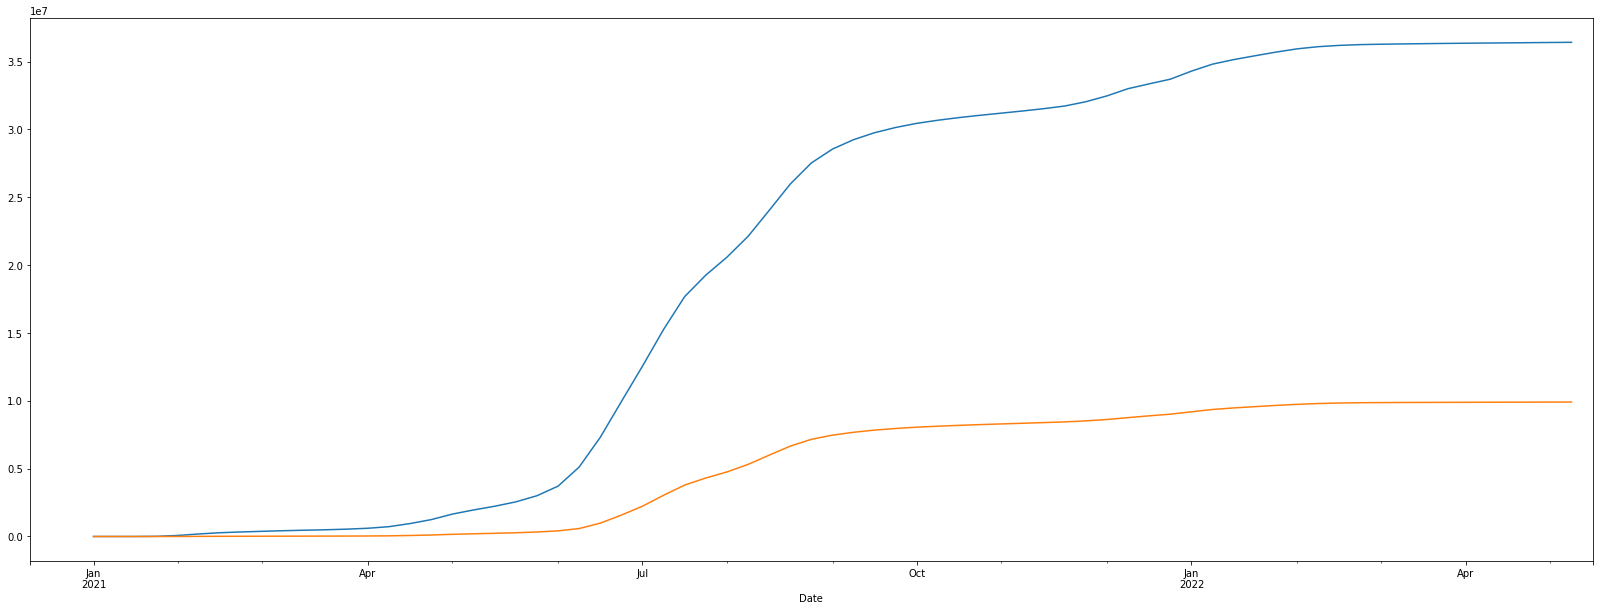

In [ ]:
pcombined_df = combined_df.pivot(index=["Date","Group"],columns="Country")
pcombined_df.iloc[pcombined_df.index.get_level_values('Group') == "25-49yr"].droplevel("Group")["SecondDose"]["France"].cumsum().plot(figsize=(28,10),label="25")
pcombined_df.iloc[pcombined_df.index.get_level_values('Group') == "15-24yr"].droplevel("Group")["SecondDose"]["France"].cumsum().plot(figsize=(28,10),label="24")
#pcombined_df.iloc[pcombined_df.index.get_level_values('Group') == "25-49yr"].droplevel("Group")["SecondDose"]["France"].cumsum().plot(figsize=(28,10))
#pcombined_df.iloc[pcombined_df.index.get_level_values('Group') == "25-49yr"].droplevel("Group")["SecondDose"]["France"].cumsum().plot(figsize=(28,10))

In [ ]:
combined_df[(combined_df["Country"]=="Austria") & (combined_df["Date"] == "2021-09-06")]

,Date,Country,Group,FirstDose,SecondDose,DoseAdditional1,new_cases,rate_14_day_per_100k
88,2021-09-06,Austria,<15yr,4333.0,3259.0,4.0,2830.0,379.000037
212,2021-09-06,Austria,15-24yr,12164.0,7983.0,81.0,2841.0,548.630441
336,2021-09-06,Austria,25-49yr,23665.0,13143.0,934.0,5528.0,340.335786
460,2021-09-06,Austria,50-64yr,6812.0,3777.0,795.0,1937.0,172.960740
584,2021-09-06,Austria,65-79yr,5556.0,3568.0,1661.0,610.0,90.348893
708,2021-09-06,Austria,80+yr,1173.0,784.0,1750.0,314.0,114.517880
23992,2021-09-06,Austria,ALL,44793.0,25706.0,5215.0,NaN,NaN
